# Estadistica aplicada
Pronostico

2 noviembre 2023

Francisco Javier Chávez Hernández 

2034204 

gpo44

El periodo utilizado fue todo el que estaba disponible para tener mas datos, llegué a utilizar desde el 2000, desde 2012 y desde 2018 pero no me convencian los valores finales, decidí utilizar mas datos. INDICE MENSUAL DEL CONSUMO DE MERCADO INTERIOR

In [612]:
#librerias basicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [613]:
#especializadas
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_predict

#ARIMA
from statsmodels.tsa.arima.model import ARIMA
#pmdarima 
import pmdarima as pm

In [614]:
#datos
IMCP=pd.read_excel('IMCMI_SA.xls')

In [615]:
IMCP.head()

,Periodos,IMCMI_SA
0,2000/01,69.592772
1,2000/02,69.884806
2,2000/03,70.017659
3,2000/04,70.403639
4,2000/05,71.107793


In [616]:
IMCP.dtypes

Periodos     object
IMCMI_SA    float64
dtype: object

In [617]:
IMCP.isnull().sum()

Periodos    0
IMCMI_SA    0
dtype: int64

In [618]:
IMCP['Periodos']=pd.to_datetime(IMCP['Periodos'], format='%Y/%m')

In [619]:
#index
IMCP=IMCP.set_index('Periodos')

In [620]:
#frecuencia
IMCP=IMCP.asfreq('MS')

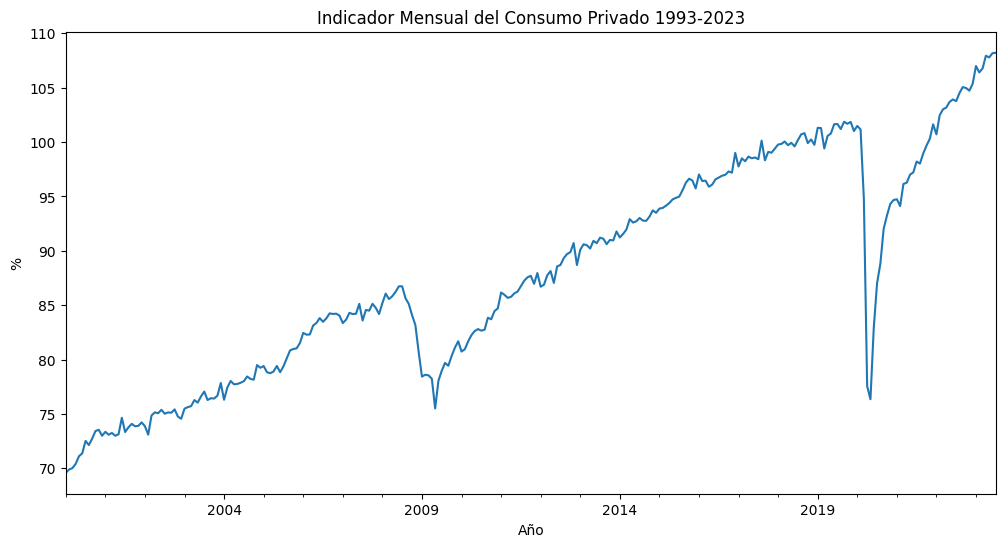

In [621]:
IMCP['IMCMI_SA'].plot(figsize=(12,6))
plt.title('Indicador Mensual del Consumo Privado 1993-2023')
plt.xlabel('Año')
#plt.xlim('2012/01','2023/07')
plt.ylabel('%');

In [622]:
#A)prueba de raiz unitaria
prueba_adf=adfuller(IMCP['IMCMI_SA'])
pvalue=prueba_adf[1]
pvalue.round(2)

0.71

No rechazamos Ho, significa que el Indicador Mensual del Consumo Privado en el Mercado Interior es una serie no estacionaria

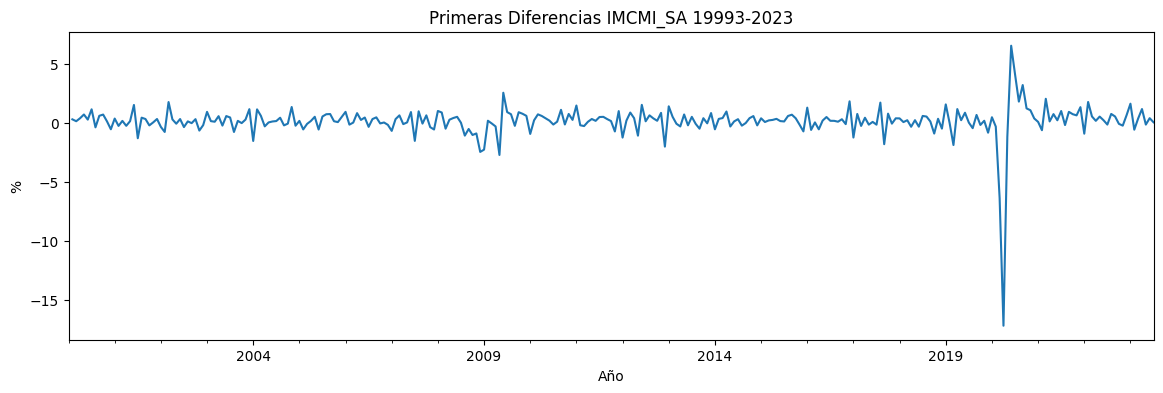

In [623]:
#B) En caso de que no sea estacionaria aplica primeras diferencias, y realiza la prueba de raíz unitaria para verificar que la serie sea estacionaria
IMCP['IMCMI_SA_dif']=IMCP['IMCMI_SA'].diff()
IMCP['IMCMI_SA_dif'].plot()
plt.title('Primeras Diferencias IMCMI_SA 19993-2023')
plt.xlabel('Año')
plt.ylabel('%');



In [624]:
#prueba de raiz unitaria
prueba_adf1=adfuller(IMCP['IMCMI_SA_dif'].dropna())
pvalue1=prueba_adf1[1]
pvalue1.round(3)

0.0

Rechazamos Ho, significa que las primeras diferencias del Indicador Mensual del Consumo Privado en el Mercado Interior es un proceso estacionario

In [625]:
#C) Si la serie no es estacionaria repite el paso b hasta que la serie sea estacionaria.


Se cumple que la serie es estacionaria

* IMCP I(1)
* 1ras diferencias del IMCP integrado I(0)

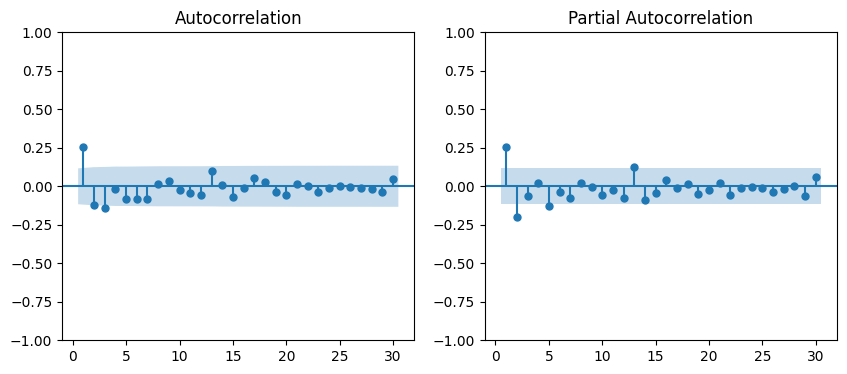

In [626]:
#D) Realiza las graficas de autocorrelación de la serie estacionaria para verificar si la serie tiene o no un componente estacional
#graficas de correlacion
ig, ax=plt.subplots(1,2,figsize=(10,4))
#1er subgrafica
plot_acf(IMCP['IMCMI_SA_dif'].dropna(),zero=False, lags=30, ax=ax[0])
#2da
plot_pacf(IMCP['IMCMI_SA_dif'].dropna(),zero=False, lags=30, ax=ax[1])
plt.show();

* (Autocorrelation). Lo sombreado es el intervalo de confianza, los coeficientes que caen fuera son distintos a cero, el resto son cero.
* No se presenta un patrón regular en las gráficas de autocorrelación, por lo que esta es una serie **sin componente estacional** 

In [627]:
#E) Utiliza auto_arima para encontrar el orden del modelo arima, dando el parámetro information_criterion, prueba y muestra el resultado, 
#con aic, bic, hqic, oob

#aic

pm.auto_arima(IMCP['IMCMI_SA'], 
              start_p=1, start_q=1,
              max_p=7, max_q=7,
              information_criterion='aic',
              seasonal=False)

ARIMA(order=(0, 1, 3), scoring_args={}, suppress_warnings=True)

In [628]:
#bic
pm.auto_arima(IMCP['IMCMI_SA'], 
              start_p=1, start_q=1,
              max_p=7, max_q=7,
              ic='bic',
              seasonal=False)

ARIMA(order=(0, 1, 3), scoring_args={}, suppress_warnings=True)

In [629]:
#hqic
pm.auto_arima(IMCP['IMCMI_SA'], 
              start_p=1, start_q=1,
              max_p=7, max_q=7,
              ic='hqic',
              seasonal=False)

ARIMA(order=(0, 1, 3), scoring_args={}, suppress_warnings=True)

In [630]:
#oob
pm.auto_arima(IMCP['IMCMI_SA'], 
              start_p=1, start_q=1,
              max_p=7, max_q=7,
              i_c='oob',
              seasonal=False)

ARIMA(order=(0, 1, 3), scoring_args={}, suppress_warnings=True)

Con todos los criterios, el IMCP muestra una SARIMA (0,1,3)(0,0,0,0)

In [631]:
# F) Utilizar el método del if con AR y MA para ver que modelos sugieren el BIC y el AIC

In [ ]:
#vamos a estimar varios modelos y guardar el AIC BIC
ic={}
for ar in range(7):
    for ma in range(7):
        print(f"AR: {ar}, MA: {ma}")
        modelo=ARIMA(IMCP['IMCMI_SA_dif'].dropna(),order=(ar,0,ma))
        resultado=modelo.fit()
        ic[(ar,ma)]=[resultado.aic, resultado.bic]

ic=pd.DataFrame(ic, index=["AIC", "BIC"]).T
ic.index=ic.index.set_names(["AR", "MA"])

In [633]:
ic.sort_values('AIC').head(1)

,,AIC,BIC
AR,MA,,
3,4,957.266741,990.043905


* Las primeras diferencias IMCMI_SA (IMCMI_SA_dif) son un modelo ARMA (3,4)=ARIMA(3,0,4)
* IMCMI_SA ARIMA (3,1,4)

In [640]:
#G) Con los dos incisos anteriores elegir el orden ARIMA a estimar
#estimar el modelo ARIMA
modelo=ARIMA(IMCP['IMCMI_SA'],order=(3,1,4))
results=modelo.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:               IMCMI_SA   No. Observations:                  283
Model:                 ARIMA(3, 1, 4)   Log Likelihood                -475.856
Date:                Thu, 02 Nov 2023   AIC                            967.712
Time:                        23:15:03   BIC                            996.847
Sample:                    01-01-2000   HQIC                           979.396
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9670      0.164     -5.882      0.000      -1.289      -0.645
ar.L2          0.4757      0.265      1.796      0.072      -0.043       0.995
ar.L3          0.7273      0.175      4.163      0.0

C:\Users\javie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Como el segundo rezago no es significativo (ar.L2) ni el segundo (ma.L2), el modelo sería un ARIMA (2,1,3)

In [635]:
IMCP['pronostico']=results.predict()
IMCP['pronostico'][0]=IMCP['IMCMI_SA'][0]
IMCP.head()

,IMCMI_SA,IMCMI_SA_dif,pronostico
Periodos,,,
2000-01-01,69.592772,NaN,69.592772
2000-02-01,69.884806,0.292033,69.592809
2000-03-01,70.017659,0.132854,69.961696
2000-04-01,70.403639,0.385980,70.003587
2000-05-01,71.107793,0.704154,70.482122


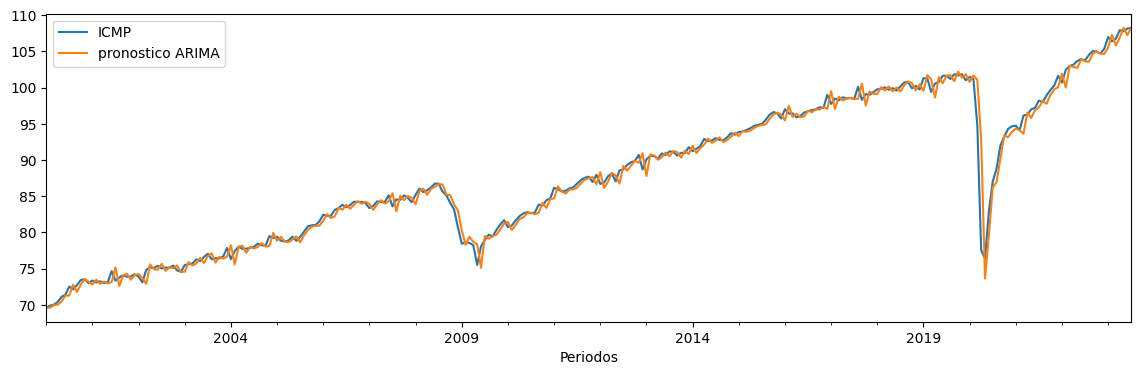

In [636]:
#grafica de la serie real vs pronostico
IMCP['IMCMI_SA'].plot(label='ICMP')
IMCP['pronostico'].plot(label='pronostico ARIMA')
plt.legend()
plt.show()

El modelo ARIMA del IMCMP logra reproducir con bastante precision el pasado de la serie, podemos utilizar el modelo para hacer pronostico

In [643]:
pronostico_IMCMP=results.predict(start='2023-07-01', end='2023-12-01')

In [642]:
pronostico_IMCMP

2023-07-01    107.800847
2023-08-01    108.403272
2023-09-01    107.902998
2023-10-01    107.894600
2023-11-01    107.669475
2023-12-01    107.519308
Freq: MS, Name: predicted_mean, dtype: float64

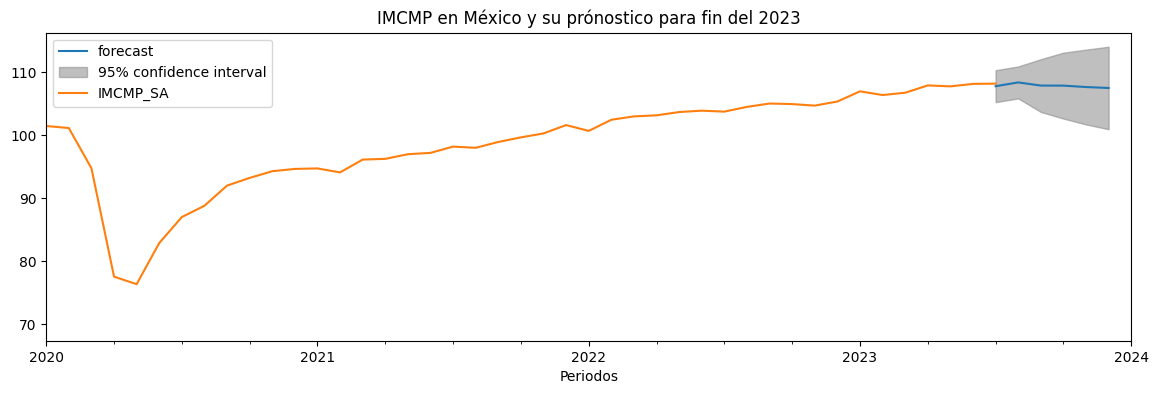

In [648]:
plot_predict(results,start='2023-07-01', end='2023-12-01')
IMCP['IMCMI_SA'].plot(label='IMCMP_SA')
plt.title('IMCMP en México y su prónostico para fin del 2023')
plt.legend(loc='upper left')
plt.xlim('2020-01-01','2024-01-01');

In [649]:
forecast=results.get_forecast(steps=5)
forecast_mean=forecast.predicted_mean
forecast_ci=forecast.conf_int()

In [650]:
inicio='2023-07-01'
fin='2024-01-01'

In [651]:
pronostico_valor=forecast_mean[inicio:fin]

In [652]:
pronostico_intervalos=forecast_ci.loc[inicio:fin]

In [653]:
#juntarlos en un dataframe
df_forecast=pd.DataFrame({
'pronóstico':pronostico_valor,
'limite inferior':pronostico_intervalos.iloc[:,0],
'limite superior':pronostico_intervalos.iloc[:,1]
})

In [654]:
pronostico_intervalos

,lower IMCMI_SA,upper IMCMI_SA
2023-08-01,105.863495,110.943048
2023-09-01,103.711290,112.094706
2023-10-01,102.657395,113.131806
2023-11-01,101.727450,113.611500
2023-12-01,100.964703,114.073912


In [655]:
df_forecast

,pronóstico,limite inferior,limite superior
2023-08-01,108.403272,105.863495,110.943048
2023-09-01,107.902998,103.711290,112.094706
2023-10-01,107.894600,102.657395,113.131806
2023-11-01,107.669475,101.727450,113.611500
2023-12-01,107.519308,100.964703,114.073912


In [662]:
print(f'El Indicador Mensual del Consumo Privado pronosticado para Noviembre de 2023 es {df_forecast.iloc[3,0].round(2)}\nCon un 95% de confianza el Indicador Mensual del Consumo Privado estará entre {df_forecast.iloc[3,1].round(2)} y {df_forecast.iloc[3,2].round(2)}')

El Indicador Mensual del Consumo Privado pronosticado para Noviembre de 2023 es 107.67
Con un 95% de confianza el Indicador Mensual del Consumo Privado estará entre 101.73 y 113.61
